## California License Plate Application Classifier
Binary Classifier Model based on training set of 23,463 personalized license plate applications received by the California DMV from 2015-2016. These applications were flagged for additional review by the Review Committee. Goal is to predict whether a license plate application will be approved or denied based on the provided information.

### Preprocessing Stage
Loading the training data and exploring the structure of the information.
I have decided that some of the data needed cleaning (replacing the NaN items and converting type) as well as a couple of features to be engineered. I decided to add a feature to check to see if there was any inappropriate words in the items, as well as to check the word count. Word count may be arbitratry but there could be some significance with the amount of explication needed. 

The processing will be replicated and centralized in the implementation stage.


In [1]:
import pandas as pd
import re

# loading the dataset
df = pd.read_csv('Downloads/applications.csv', dtype=str)

# defining function terms for new feature of inappropriate words
inappropriate_words = [
        # curse words and inappropriate words based on examples from selection
        # please ignore this haha
        "fuck", "shit", "asshole", "bitch", "bitchy" "bastard", "cunt", "pussy", "dick", "prick", "twat",
        "faggot", "dyke", "chink", "nigger", "spaz", "retard", "cripple", "gimp", "gang", "hitler", 
        "nazi", "racist", "sexist", "homophobic", "transphobic", "misogynistic", "pedophile", "incest", 
        "rape", "murder", "violence", "bomb", "gun", "drug", "alcohol", "nigga", "porn"
    ]
# defining function to check all of the examples and set bool
def contains_inappropriate_word(text):
    for word in inappropriate_words:
        if word.lower() in text.lower():
            return True
    return False
    
# feature engineering
df['reviewer_comments'] = df['reviewer_comments'].astype(str)
df['contains_inappropriate_word'] = df['reviewer_comments'].apply(contains_inappropriate_word)
df['word_count'] = df['reviewer_comments'].apply(lambda x: len(x.split()))

# cleaning data so there is no NaN 
df.fillna('', inplace=True)

# encoding the status in inappropriate words to int
df = df[df['status'].isin(['N', 'Y'])]
df['status'] = df['status'].map({'N': 0, 'Y': 1})
df['contains_inappropriate_word'] = df['contains_inappropriate_word'].astype(int)

# checking all of the data out. looks to be good!
print(df.dtypes)
print(df.head())
print(f"Shape of DataFrame after preprocessing: {df.shape}")

plate                          object
review_reason_code             object
customer_meaning               object
reviewer_comments              object
status                          int64
contains_inappropriate_word     int32
word_count                      int64
dtype: object
      plate review_reason_code  \
0   AZIZ714                  2   
1   BATBOX1                  1   
2    BBOMBS                  2   
3   BEACHY1                  4   
4  BLK PWR5                  2   

                                    customer_meaning  \
0                                          LAST NAME   
1  BATMOBILE (BATMAN) PLUS SHAPE OF VEHICLE (SCIO...   
2                                 NO MICRO AVAILABLE   
3                                     LOVE THE BEACH   
4                                 STRENGTH OF FAMILY   

            reviewer_comments  status  contains_inappropriate_word  word_count  
0               714 AREA CODE       0                            0           3  
1               

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# splitting the data first and set 20% for testing 
X = df[['plate', 'review_reason_code', 'customer_meaning', 'reviewer_comments', 'word_count', 'contains_inappropriate_word']]
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# encode categorical features after splitting
categorical_cols = ['plate', 'review_reason_code', 'customer_meaning', 'reviewer_comments']  # Decide on plate encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# combine encoded categorical features with non-categorical features
X_train_encoded = np.hstack([X_train_encoded, X_train[['word_count', 'contains_inappropriate_word']].values])
X_test_encoded = np.hstack([X_test_encoded, X_test[['word_count', 'contains_inappropriate_word']].values])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([encoded_feature_names, ['word_count', 'contains_inappropriate_word']])

# replace original categorical columns with encoded features and keep all feature names
X_train = pd.DataFrame(X_train_encoded, columns=all_feature_names)
X_test = pd.DataFrame(X_test_encoded, columns=all_feature_names)

### Analysis Stage
To begin, I wanted to test a few different models. I went with a logistic regression, random forest and a neural network. I figured that the data was a bit too simplistic for something more advanced like an advanced neural network or some pre-trained model. I figured these would overfit or perform poorly. After some testing, this seemed to be the case. I trained the data on DistillBERT and a couple other models, but got some poor results/poor performance without implementing on cloud (removed some unneccesary code prior to finishing project).

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# training a simple logistic regression model
# balanced the classes because rejected plates are significantly higher than accepted
model_lr = LogisticRegression(max_iter=1000, solver='liblinear')
model_lr.fit(X_train, y_train)

# evaluate the model
accuracy = model_lr.score(X_test, y_test)
print("Accuracy:", accuracy)
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))


Accuracy: 0.8220230473751601
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      3741
           1       0.76      0.17      0.28       945

    accuracy                           0.82      4686
   macro avg       0.79      0.58      0.59      4686
weighted avg       0.81      0.82      0.77      4686



Accuracy of 82% is not bad after the initial logistic regression- but the recall for approved plates being only around 17% shows an issue with the data. Even after some small feature engineering, there is an issue. We will try a few other models and compare the results. Afterwards, we can work towards improvements such as balancing the approved and disapproved data sets.

First, we will try RandomForest and afterwards a neural network

In [4]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

model_rfc = RandomForestClassifier(n_estimators=25, max_features='log2', random_state=42, n_jobs=-1)
model_rfc.fit(X_train, y_train)

# evaluate the model
accuracy = model_rfc.score(X_test, y_test)
print("Accuracy:", accuracy)
y_pred = model_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy: 0.8215962441314554
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      3741
           1       0.80      0.15      0.26       945

    accuracy                           0.82      4686
   macro avg       0.81      0.57      0.58      4686
weighted avg       0.82      0.82      0.77      4686



The results are similar to the logistic regression, but the recall is even lower for approved plates. Going to test with the neural network to see the performance, but definitely need to work on the data.

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score

model_nn = tf.keras.models.Sequential([
tf.keras.layers.InputLayer(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy')

# training
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# evaluate the model
y_pred_probs = model_nn.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_classes))


Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5252 - val_loss: 0.4488
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2649 - val_loss: 0.5386
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0180 - val_loss: 0.5429
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0027 - val_loss: 0.5691
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0011 - val_loss: 0.5575
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.6813e-04 - val_loss: 0.5759
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0020 - val_loss: 0.6767
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0010 - val_loss: 0.8259
Epoch 9/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.7583e-04 - val_loss: 0.6249
Epoch 10/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0062 - val_loss: 0.7019
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6880068288518992
              precision    recall  f1-score   supp

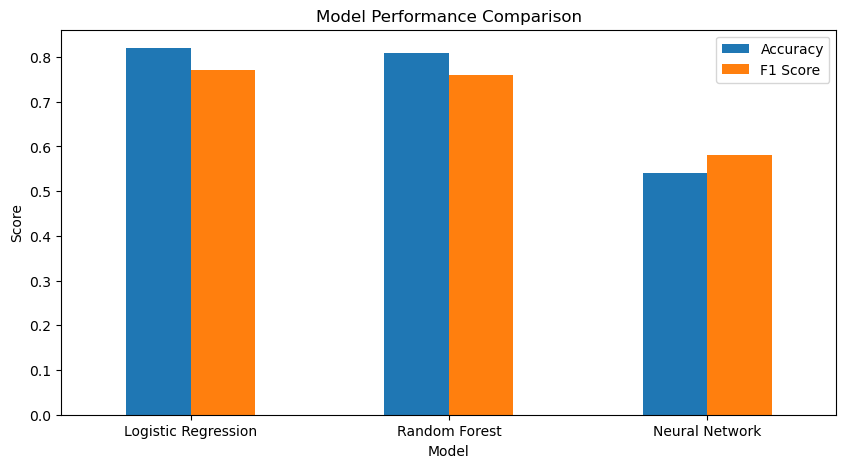

In [6]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# define models and their performance metrics
models = ['Logistic Regression', 'Random Forest', 'Neural Network'] 
accuracies = [0.82, 0.81, 0.54] #estimated accuracies based off prior runs
f1_scores = [0.77, 0.76, 0.58] #likewise 
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

# plotting
performance_df.set_index('Model').plot(kind='bar', figsize=(10, 5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


Given that we have a relatively small feature set and simplistic data, the NN seems like it is overfitting/performing unusually, it’s worth going with the simpler models. This should help get more realistic and reliable results.

After running both of these models, it seems that the recall for approved is quite low on both. The logistic regression performed a bit better on the data, and the use-case is best for this data in my opinion. I plan on making synthetic approved plates to help balance out the data set and then I will continue to work with the logistic regression.

Using SMOTE (Synthetic Minority Over-sampling Technique) is designed to create synthetic samples for the minority class to balance the class distribution. The minority class being the approved plates. I am using a cleaning method, Tomek Links, to help remove noisy samples and reduce overfitting.

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

# initialize SMOTEtomek
smote_tomek = SMOTETomek(smote=SMOTE(random_state=42, k_neighbors=2))

# fit and resample the data with 
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# checking shape of both
print("Original dataset shape:", Counter(y_train))
print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0: 15016, 1: 3728})
Resampled dataset shape: Counter({0: 15007, 1: 15007})


Since Logistic Regression performed slightly better, let's try to run it with our resampled dataset

In [8]:
# training a simple logistic regression model with new dataset
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# splitting the resampled dataset 
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_lr_2 = LogisticRegression(max_iter=1000, solver='liblinear') #liblinear supports L2 regularization by default
model_lr_2.fit(X_train_resampled, y_train_resampled)

# evaluate the model
accuracy = model_lr_2.score(X_test, y_test)
print("Accuracy:", accuracy)
y_pred = model_lr_2.predict(X_test)
print(classification_report(y_test, y_pred))


Accuracy: 0.9270364817591205
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3020
           1       0.94      0.91      0.93      2983

    accuracy                           0.93      6003
   macro avg       0.93      0.93      0.93      6003
weighted avg       0.93      0.93      0.93      6003



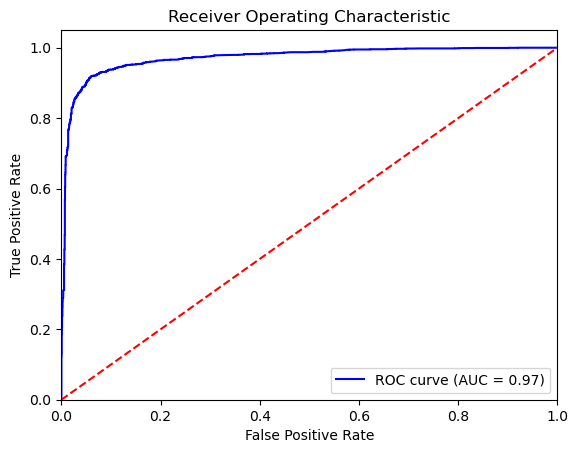

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report
)

# defining plot for roc
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Get predicted probabilities
y_pred_proba = model_lr_2.predict_proba(X_test)[:, 1]  # Probability of the positive class
plot_roc_curve(y_test, y_pred_proba)


The AUC score quantifies the ability of the model to discriminate between the approved and disapproved classes. An AUC of 0.97 indicates excellent performance- it shows that the model is highly effective in distinguishing between the two classes. It’s important to consider other metrics like the f1-score and accuracy score which are both quite good for this model as well.

The results are much better than before. There could be more tinkering to get the accuracy higher but over 91% and decent recall is decent performance. 
Since the precision and recall for both classes are high, the model seems to handle both classes well. The level i accuracy and the balance of precision and recall suggest that overfitting might not be a huge issue. 

Finished sparse matrix
Cross-Validation Accuracy Scores: [0.91880075 0.91753436 0.91732611 0.91795085 0.91732611]
Mean CV Accuracy: 0.9177876384527476
Standard Deviation of CV Accuracy: 0.0005555524027143167


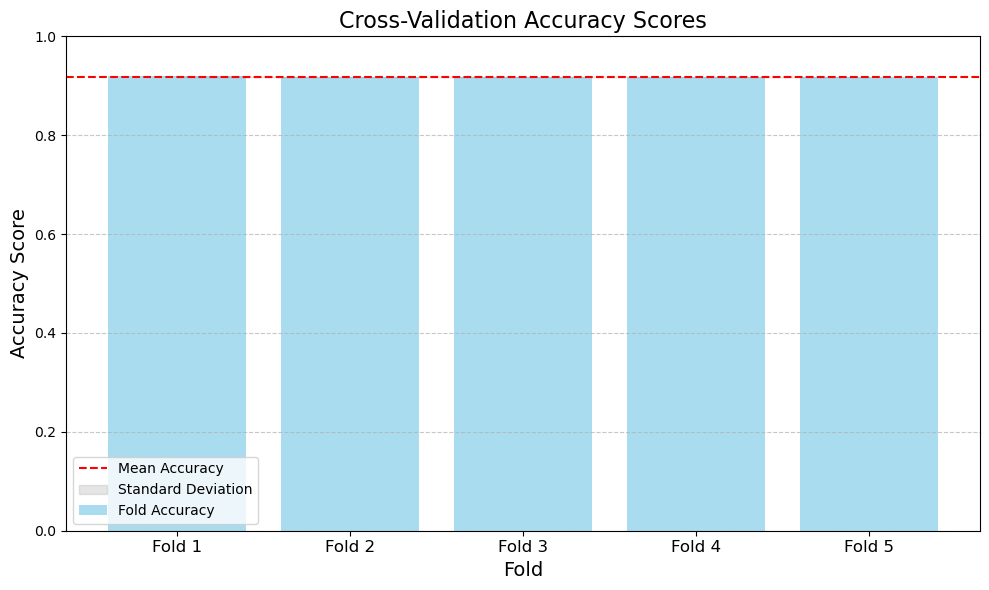

In [10]:
from sklearn.model_selection import cross_val_score
from scipy import sparse

# convert the resampled dataset to a sparse matrix to save memory
X_resampled_sparse = sparse.csr_matrix(X_train_resampled)

print("Finished sparse matrix")

# perform 5-fold cross-validation
cv_scores = cross_val_score(model_lr_2, X_resampled_sparse, y_train_resampled, cv=5, scoring='accuracy', n_jobs=1)

# print the results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std()}")

# plotting the cvv scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='skyblue', alpha=0.7, label='Fold Accuracy')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label='Mean Accuracy')
plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(), cv_scores.mean() + cv_scores.std(), color='gray', alpha=0.2, label='Standard Deviation')

# adding labels
plt.title('Cross-Validation Accuracy Scores', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy Score', fontsize=14)
plt.xticks(range(1, 6), [f'Fold {i}' for i in range(1, 6)], fontsize=12)
plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for accuracy
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

These are the accuracy scores obtained from 5 different cross-validation folds. Cross-validation splits the data into 5 folds, where the model is trained on 4 folds and tested on the remaining fold. This process is repeated 5 times with a different fold held out each time for testing.
The results show that the model is consistently performing well across different splits of your data. 

The standard deviation shows how much the accuracy varies between the different folds. The standard deviation is very low which shows that the model's performance is consistent across different folds of the data. The model definitely has room for improvement by doing some more fine-tuning, more feature enhancing, ect. For this case, I think the performance is solid and the ideas and thought process has been written out and explained well. I will move on to the implementation of this model for predicting new plates approval.

### Implementation Stage

Based on the first two stages of the project, I decided to go with a logistic regression model for the binary classification trained on a SMOTE synthetic data set along with a couple of engineered features added to strengthen the data. I will go ahead and create the entire pipeline for the data to be processed within the prediction function and run some testing on it and study the results.

Below will be the entire pipeline, re-encoding data and training the model.

In [11]:
import re
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import numpy as np

####################################
# Load and prepare training data 
####################################

df = pd.read_csv('Downloads/applications.csv', dtype=str)

# defining function terms for new feature of inappropriate words
# pls ignore
inappropriate_words = [
    "fuck", "shit", "asshole", "bitch", "bitchy", "bastard", "cunt", "pussy", "dick", "prick", "twat",
    "faggot", "dyke", "chink", "nigger", "spaz", "retard", "cripple", "gimp", "gang", "hitler", 
    "nazi", "racist", "sexist", "homophobic", "transphobic", "misogynistic", "pedophile", "incest", 
    "rape", "murder", "violence", "bomb", "gun", "drug", "alcohol", "nigga", "porn"
]

# defining function to check all of the examples and set bool
def contains_inappropriate_word(text):
    for word in inappropriate_words:
        if word.lower() in text.lower():
            return 1
    return 0

# feature engineering
df['reviewer_comments'] = df['reviewer_comments'].astype(str)
df['contains_inappropriate_word'] = df['reviewer_comments'].apply(contains_inappropriate_word)
df['word_count'] = df['reviewer_comments'].apply(lambda x: len(x.split()))

# cleaning data so there are no NaN 
df.fillna('', inplace=True)

# encoding the status in inappropriate words to int
df = df[df['status'].isin(['N', 'Y'])]
df['status'] = df['status'].map({'N': 0, 'Y': 1})

# split the data first and set 20% for testing 
X = df[['plate', 'review_reason_code', 'customer_meaning', 'reviewer_comments', 'word_count', 'contains_inappropriate_word']]
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# encode categorical features after splitting
categorical_cols = ['plate', 'review_reason_code', 'customer_meaning', 'reviewer_comments']  # Decide on plate encoding
encoder_final = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder_final.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder_final.transform(X_test[categorical_cols])

# combine features
X_train_encoded = np.hstack([X_train_encoded, X_train[['word_count', 'contains_inappropriate_word']].values])
X_test_encoded = np.hstack([X_test_encoded, X_test[['word_count', 'contains_inappropriate_word']].values])
encoded_feature_names = encoder_final.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([encoded_feature_names, ['word_count', 'contains_inappropriate_word']])

# replace original categorical columns with encoded features and keep all feature names
X_train = pd.DataFrame(X_train_encoded, columns=all_feature_names)
X_test = pd.DataFrame(X_test_encoded, columns=all_feature_names)

# initialize SMOTEtomek and fit and resample the data
smote_tomek = SMOTETomek(smote=SMOTE(random_state=42, k_neighbors=2))
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# splitting the resampled dataset 
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
final_model = LogisticRegression(max_iter=1000, solver='liblinear') # liblinear supports L2 regularization by default
final_model.fit(X_train_resampled, y_train_resampled)

print("Finished pre-processing")

Finished pre-processing


In [12]:
import re
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import numpy as np

####################################
# Define the prediction function
####################################
def model_predict(plate: str, review_reason_code: str, customer_meaning: str, reviewer_comments: str) -> bool:

    input_data = pd.DataFrame({
        'plate': [str(plate)],
        'review_reason_code': [str(review_reason_code)],  
        'customer_meaning': [str(customer_meaning)],      
        'reviewer_comments': [str(reviewer_comments)],    
        'word_count': [len(reviewer_comments.split())],   
        'contains_inappropriate_word': [contains_inappropriate_word(reviewer_comments)]
    })

    input_data.fillna('', inplace=True)
    
    # handle categorical encoding
    categorical_cols = ['plate', 'review_reason_code', 'customer_meaning', 'reviewer_comments']
    encoded_features = encoder_final.transform(input_data[categorical_cols])    
    combined_features = np.hstack([encoded_features, input_data[['word_count', 'contains_inappropriate_word']].values])

    # make the prediction
    prediction = final_model.predict(combined_features)
    prediction_proba = final_model.predict_proba(combined_features)
    
    # show the probabilities 0 vs 1
    print(f"Prediction Probabilities: {prediction_proba}")
    return bool(prediction[0])

# testing the function with some example inputs
result = model_predict("LDYNBLU", "3", "NO MICRO", "LADY IN BLUE. GANG COLORS?") #approved even with "gang" in the reviewer comments
print(f"Prediction: {'Approved' if result else 'Denied'}")


Prediction Probabilities: [[0.44105944 0.55894056]]
Prediction: Approved


C:\Users\Matthew Sherlin\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Matthew Sherlin\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Final Thoughts
Overall, the implementation shows promise with a solid foundation, some feature engineering and data handling. The model works quite well with examples from the test set that I have checked through the the final prediction function. I have noticed that there is some denied predictions to manual data entries that I created which I assumed would be approved. This could be due to some overfitting or some other issue in the model. Addressing the limitations around model performance, data quality, and complexity could definitely enhance its effectiveness. Continuous evaluation and improvement through iterative testing and refinement would lead to better predictions for sure.

Overall this project was quite enjoyable. It was time consuming to locally run all of the models and try many different techniques, but I really enjoyed getting through it.
